Dear Professor,

I hope you're doing well. To ensure that the code runs correctly on your system, could you please follow this step:

Kindly ensure that the dataset file loanapp.csv is placed in the same directory as the Python script or Jupyter notebook you are running.

In [36]:
import os
import pandas as pd

# Construct file path dynamically
file_path = os.path.join(os.getcwd(), "loanapp.csv")
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()


,occ,loanamt,action,msa,suffolk,appinc,typur,unit,married,dep,...,approve,mortno,mortperf,mortlat1,mortlat2,chist,multi,loanprc,thick,white
0,1,89,1,1120,0,72,0,1,0,0,...,1,0,1,0,0,1,0,0.754237,0,1
1,1,128,3,1120,0,74,0,1,1,1,...,0,0,1,0,0,1,0,0.800000,1,1
2,1,128,1,1120,0,84,3,1,0,0,...,1,0,1,0,0,1,0,0.895105,1,1
3,1,66,1,1120,0,36,0,1,1,0,...,1,0,1,0,0,0,0,0.600000,0,1
4,1,120,1,1120,0,59,8,1,1,0,...,1,0,1,0,0,1,0,0.895522,0,1


In [31]:
# Select relevant columns
columns = ["approve", "hrat", "obrat", "loanprc", "unem", "dep", "sch", 
           "cosign", "pubrec", "married", "white", "male"]
df_subset = df[columns].copy()

# Convert categorical variables to numeric (ensure correct types)
df_subset = df_subset.apply(pd.to_numeric, errors="coerce")

# Drop rows with missing values
df_subset = df_subset.dropna()

# Display summary statistics
df_subset.describe()

,approve,hrat,obrat,loanprc,unem,dep,sch,cosign,pubrec,married,white,male
count,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000
mean,0.876205,24.800081,32.389797,0.770431,3.888534,0.771689,0.770167,0.028919,0.068493,0.659564,0.846271,0.813293
std,0.329431,7.130267,8.276594,0.189467,2.171818,1.105423,0.420832,0.167622,0.252654,0.473976,0.360780,0.389775
min,0.000000,1.000000,0.000000,0.021053,1.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,28.000000,0.700000,3.100000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,25.800000,33.000000,0.800000,3.200000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,29.000000,37.000000,0.898906,3.900000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,72.000000,95.000000,2.571429,10.600000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
import time
import numpy as np
import scipy.stats as stats

# Extract outcome variable and covariates
y = df_subset["approve"].values  # Binary response variable
X = df_subset.drop(columns=["approve"]).values  # Covariates
X = np.column_stack((np.ones(X.shape[0]), X))  # Add intercept

# Function for Gibbs Sampling with optimized truncated normal sampling
def gibbs_sampler(X, y, num_samples=15000, burn_in=5000):
    # n = number of observations, p = number of predictor variables (including intercept)
    n, p = X.shape
    beta = np.zeros(p) # Initial guess for regression coefficients (beta)
    beta_samples = np.zeros((num_samples, p)) # Array to store the sampled betas over iterations
    y_star = np.random.normal(size=n) # Latent variable y_star (unobserved in the probit model)

    # Define the prior for beta (mean of zero, large covariance for weak prior)
    beta_prior_mean = np.zeros(p)
    beta_prior_cov = np.eye(p) * 1000 # Large variance for a non-informative prior

    start_time = time.time()

    for i in range(num_samples):
        # Sample y_star using truncated normal sampling
        mean_y_star = X @ beta # Linear predictor (X * beta)

        # For y = 1, sample y_star from truncated normal distribution with lower bound of 0
        y_star[y == 1] = stats.truncnorm.rvs(0 - mean_y_star[y == 1], np.inf, loc=mean_y_star[y == 1], scale=1)

        # For y = 0, sample y_star from truncated normal distribution with upper bound of 0
        y_star[y == 0] = stats.truncnorm.rvs(-np.inf, 0 - mean_y_star[y == 0], loc=mean_y_star[y == 0], scale=1)

        # Sample beta (regression coefficients) given the latent variable y_star
        beta_cov = np.linalg.inv(np.linalg.inv(beta_prior_cov) + X.T @ X) # Posterior covariance of beta
        beta_mean = beta_cov @ (np.linalg.inv(beta_prior_cov) @ beta_prior_mean + X.T @ y_star) # Posterior mean of beta
        beta = np.random.multivariate_normal(beta_mean, beta_cov) # Draw beta from multivariate normal

        # Store the sampled beta values
        beta_samples[i, :] = beta

        if i % burn_in == 0:
            print(f"Iteration {i}/{num_samples} completed...")

    end_time = time.time()
    print(f"Gibbs Sampling completed in {end_time - start_time:.2f} seconds.")

    return beta_samples[burn_in:]

# Run the optimized Gibbs Sampler
beta_samples = gibbs_sampler(X, y)

# Compute posterior statistics: mean and credible intervals (2.5% and 97.5% percentiles)
beta_mean = np.mean(beta_samples[5000:], axis=0)
beta_ci_lower = np.percentile(beta_samples, 2.5, axis=0)
beta_ci_upper = np.percentile(beta_samples, 97.5, axis=0)

# Store results in a DataFrame
beta_results = pd.DataFrame({
    "Variable": ["Intercept"] + list(df_subset.columns[1:]),
    "Mean": beta_mean,
    "2.5% CI": beta_ci_lower,
    "97.5% CI": beta_ci_upper
})

# Display results
beta_results

Iteration 0/15000 completed...
Iteration 5000/15000 completed...
Iteration 10000/15000 completed...
Gibbs Sampling completed in 32.22 seconds.


,Variable,Mean,2.5% CI,97.5% CI
0,Intercept,2.376749,1.796191,2.971483
1,hrat,0.012028,-0.001355,0.025292
2,obrat,-0.031189,-0.043040,-0.019573
3,loanprc,-1.001440,-1.468091,-0.555881
4,unem,-0.034722,-0.067470,-0.001776
5,dep,-0.046144,-0.120025,0.029790
6,sch,0.041872,-0.150148,0.223103
7,cosign,0.063333,-0.384107,0.530227
8,pubrec,-0.983844,-1.220256,-0.749614
9,married,0.250771,0.072693,0.438857


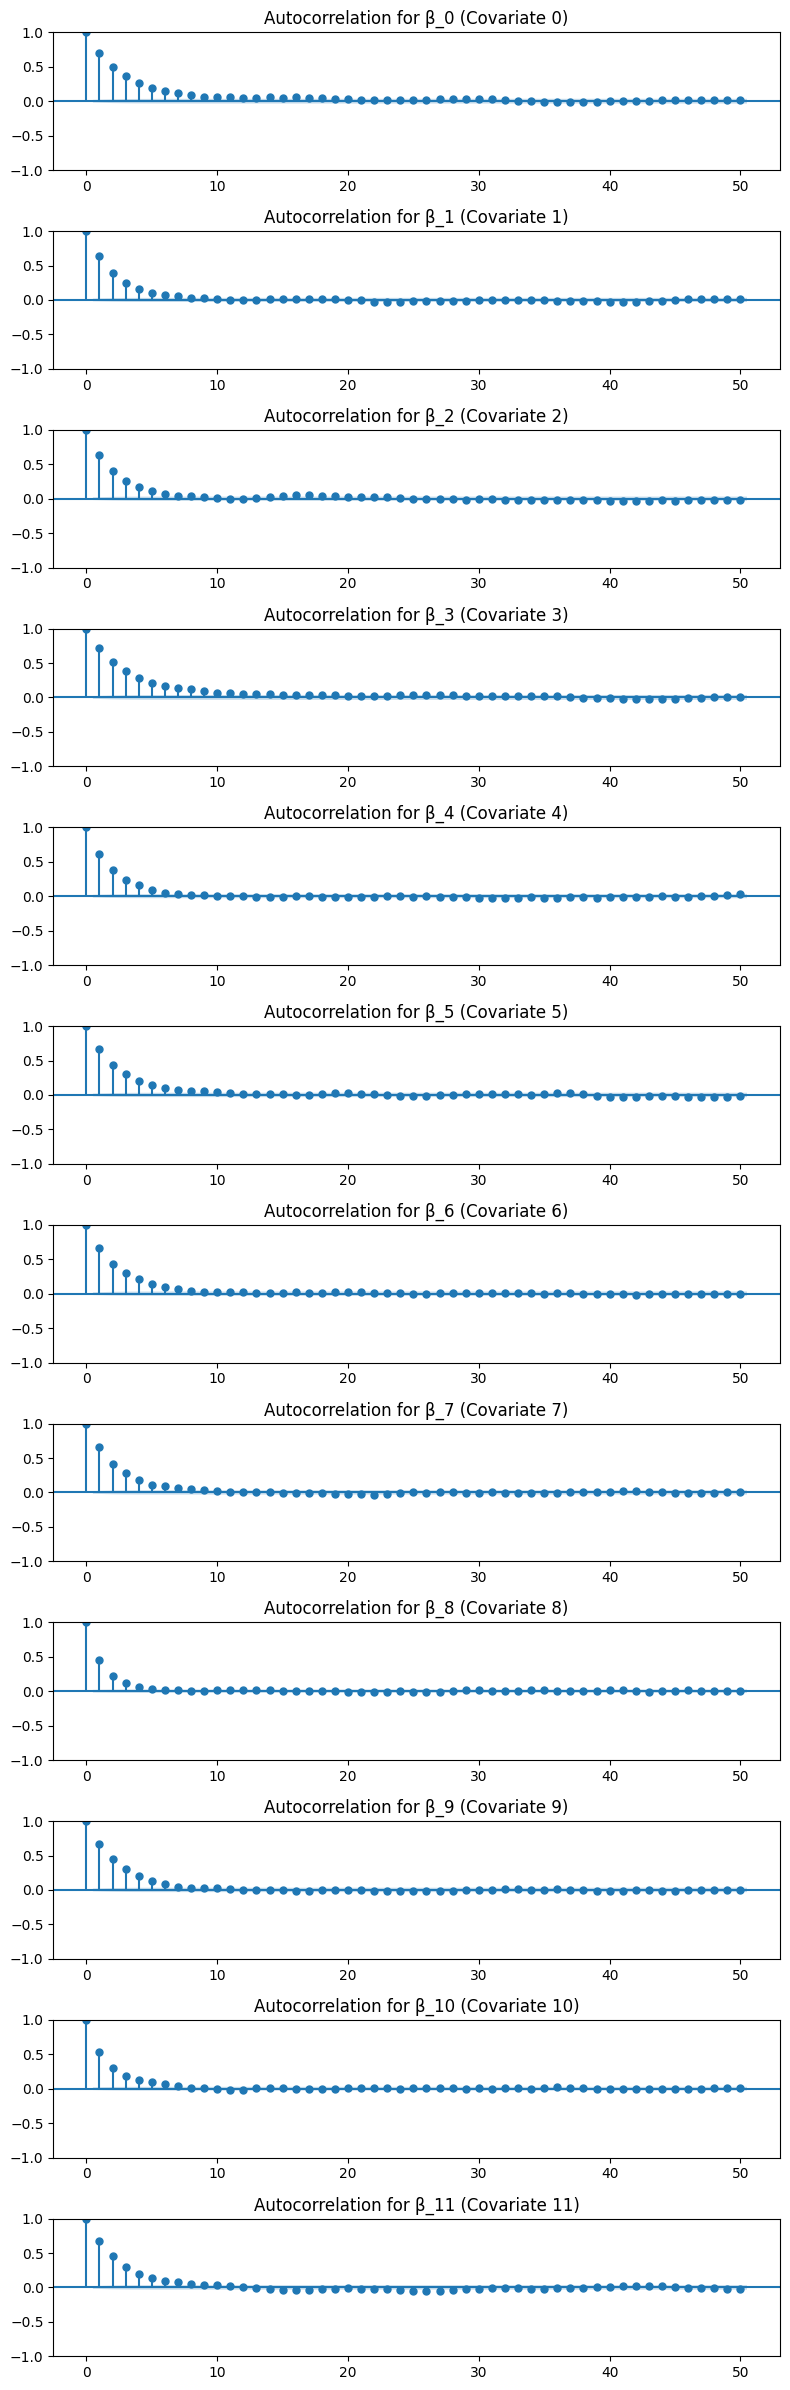

In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

num_covariates = beta_samples.shape[1]  # Number of coefficients (including intercept)

fig, axes = plt.subplots(nrows=num_covariates, ncols=1, figsize=(8, 2 * num_covariates))

for i in range(num_covariates):
    sm.graphics.tsa.plot_acf(beta_samples[:, i], lags=50, ax=axes[i])
    axes[i].set_title(f"Autocorrelation for β_{i} (Covariate {i})")

plt.tight_layout()
plt.show()

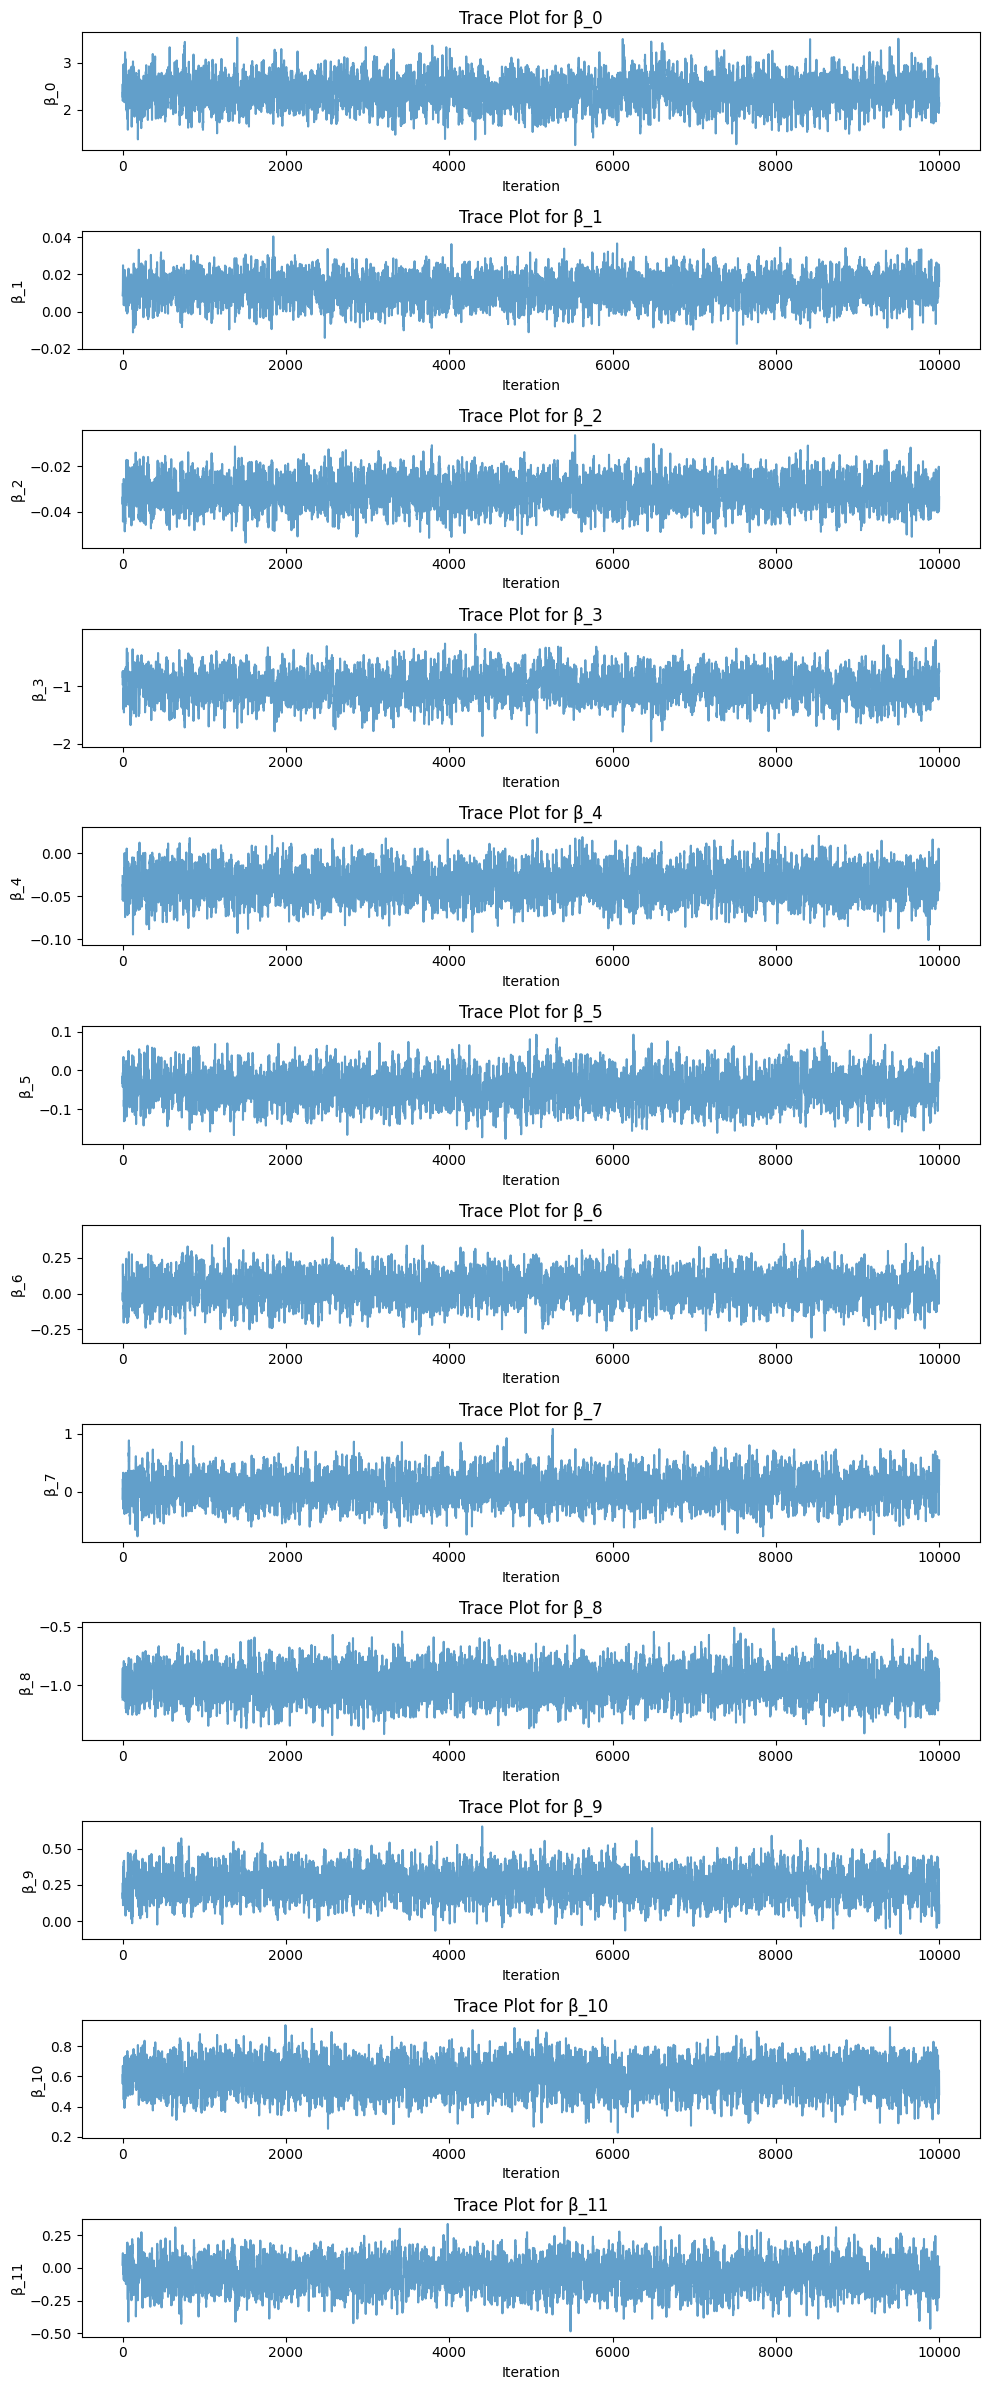

In [5]:
# Plot trace plots for all coefficients
fig, axes = plt.subplots(nrows=beta_samples.shape[1], figsize=(10, 2 * beta_samples.shape[1]))

for i in range(beta_samples.shape[1]):
    axes[i].plot(beta_samples[:, i], alpha=0.7)
    axes[i].set_ylabel(f"β_{i}")
    axes[i].set_xlabel("Iteration")
    axes[i].set_title(f"Trace Plot for β_{i}")

plt.tight_layout()
plt.show()

In [ ]:
import xarray as xr
#!pip install arviz
import arviz as az

# Split single chain into 4 pseudo-chains (4, 5000, 6)
beta_samples_split = beta_samples.reshape(4, 5000, 6)

# Create xarray Dataset to organize and label the data
# The dimensions (dims) are "chain", "draw", and "param"
# - "chain": represents the number of pseudo-chains (4 in this case)
# - "draw": represents the individual samples from each chain (5000 samples per chain)
# - "param": represents the regression coefficients (6 parameters including the intercept)
dims = ["chain", "draw", "param"]

# The coordinates for each dimension are created using numpy's arange to label each axis:
coords = {
    "chain": np.arange(beta_samples_split.shape[0]), # Indices for the pseudo-chains (0, 1, 2, 3)
    "draw": np.arange(beta_samples_split.shape[1]), # Indices for the samples within each chain (0 to 4999)
    "param": np.arange(beta_samples_split.shape[2]), # Indices for the parameters (0 to 5)
}

# Convert the reshaped beta_samples into an xarray DataArray and then into a Dataset
# The DataArray is the core object that holds the posterior samples with appropriate dimensions and coordinates
posterior_data = xr.DataArray(
    beta_samples_split,
    dims=dims,
    coords=coords,
    name="beta"
).to_dataset()

# Convert the xarray Dataset into ArviZ's InferenceData format for easier analysis and visualization
inference_data = az.InferenceData(posterior=posterior_data)

# Compute diagnostics to assess the convergence and quality of the MCMC samples
# Gelman-Rubin R-hat statistic checks for convergence across chains
print("Gelman-Rubin R-hat:", az.rhat(inference_data))

# Effective Sample Size (ESS) is a measure of the number of independent samples we have
# A higher ESS suggests that the samples are not highly autocorrelated and represent more independent information
print("Effective Sample Size:", az.ess(inference_data))

Gelman-Rubin R-hat: <xarray.Dataset>
Dimensions:  (param: 6)
Coordinates:
  * param    (param) int32 0 1 2 3 4 5
Data variables:
    beta     (param) float64 1.0 1.001 1.0 1.0 1.0 1.001
Effective Sample Size: <xarray.Dataset>
Dimensions:  (param: 6)
Coordinates:
  * param    (param) int32 0 1 2 3 4 5
Data variables:
    beta     (param) float64 1.115e+04 4.123e+03 ... 1.498e+04 3.846e+03


In [7]:
import numpy as np

# Function for Geweke test
def geweke_test(samples, first_fraction=0.1, last_fraction=0.5):
    """
    Perform Geweke diagnostic for convergence.
    :param samples: MCMC samples (after burn-in)
    :param first_fraction: Fraction of samples to use for the first segment (default 10%)
    :param last_fraction: Fraction of samples to use for the last segment (default 50%)
    :return: Z-scores for the Geweke test
    """
    n_samples = len(samples)
    
    # Determine indices for the first and last segments
    first_segment = samples[:int(first_fraction * n_samples)]
    last_segment = samples[int((1 - last_fraction) * n_samples):]

    # Compute means and variances for both segments
    first_mean = np.mean(first_segment, axis=0)
    last_mean = np.mean(last_segment, axis=0)
    first_var = np.var(first_segment, axis=0) / len(first_segment)
    last_var = np.var(last_segment, axis=0) / len(last_segment)

    # Compute Geweke Z-scores
    z_scores = (first_mean - last_mean) / np.sqrt(first_var + last_var)

    return z_scores

# Perform Geweke test for each beta coefficient
geweke_results = []
for i in range(beta_samples.shape[1]):
    z_scores = geweke_test(beta_samples[:, i])
    geweke_results.append({
        "Variable": ["Intercept"] + list(df_subset.columns[1:])[i:i+1],
        "Geweke Z-score": z_scores
    })

geweke_df = pd.DataFrame(geweke_results)

# Display the Geweke test results
geweke_df

,Variable,Geweke Z-score
0,"[Intercept, hrat]",1.586970
1,"[Intercept, obrat]",1.058825
2,"[Intercept, loanprc]",-2.519440
3,"[Intercept, unem]",0.135787
4,"[Intercept, dep]",-1.589626
5,"[Intercept, sch]",4.335037
6,"[Intercept, cosign]",-2.347054
7,"[Intercept, pubrec]",-0.505305
8,"[Intercept, married]",-0.260149
9,"[Intercept, white]",-0.321967


## Extension of Gibbs Sampling Algorithm with Wishart Prior

In this extended version of our Gibbs sampler, we introduce a **Wishart prior** as it was done in Lab 5 to model the uncertainty in the covariance matrix of the regression coefficients. Instead of assuming a fixed covariance structure, this approach allows the covariance to evolve over the iterations of the sampler. Here, we denote the inverse covariance matrix as `Sigma^(-1)` and update it at each step.

The **Wishart distribution** is a natural choice as a conjugate prior for covariance matrices in multivariate normal models. It helps us capture the uncertainty and potential correlations among the regression coefficients. The distribution is defined by a scale matrix `Sigma_0` and degrees of freedom `nu`, which together shape the distribution.

### The model updates the covariance structure in the following way:

1. **Gibbs Sampling Step:** At each iteration, we sample the inverse covariance matrix `Sigma^(-1)` from the Wishart distribution, using updated degrees of freedom (`nu`) and scale matrix (`Sigma_0`) based on the current state of the model.
2. **Calculating Covariance:** We then compute the covariance matrix `Sigma` as the inverse of the sampled `Sigma^(-1)`.
3. **Sampling Regression Coefficients:** The regression coefficients `beta` are sampled conditionally on this updated covariance matrix, meaning that the latest covariance information directly influences their posterior distribution.

### Why Use a Wishart Prior?

Introducing a Wishart prior allows our model to capture correlations between regression coefficients, which is important when predictors are not independent. For example, in a mortgage loan application context, variables such as housing expenditure and loan amount might be correlated. Allowing the covariance structure to be data driven makes the model better suited to capture these real world relationships.

By letting the data inform the covariance matrix, the model can more accurately represent the underlying dynamics which will lead to potentially improved predictions.

### Considerations and Challenges

While adding the Wishart prior adds flexibility, it also introduces extra complexity. It requires careful tuning of parameters like the degrees of freedom (`nu`) and the scale matrix (`Sigma_0`). We should compare the performance of this extended model against a simpler model with fixed priors to determine if the added complexity provides significant benefits. After considering the change, our model still performed well almost without any change in the predictions; however, we still wanted to keep this method too.

In [32]:
import time
import numpy as np
import scipy.stats as stats

# Extract outcome variable and covariates
y = df_subset["approve"].values  # Binary response variable (1 = approve, 0 = reject)
X = df_subset.drop(columns=["approve"]).values  # Covariates (independent variables)
X = np.column_stack((np.ones(X.shape[0]), X))  # Add intercept column (constant term)

def gibbs_sampler(X, y, num_samples=15000, burn_in=5000):
    """
    Gibbs sampler for Bayesian probit regression with a Wishart prior on the covariance matrix.
    
    Args:
        X (numpy.ndarray): Design matrix (including intercept).
        y (numpy.ndarray): Binary response variable.
        num_samples (int): Total number of MCMC iterations.
        burn_in (int): Number of initial samples to discard (burn-in period).
    
    Returns:
        beta_samples (numpy.ndarray): Posterior samples for beta coefficients.
        inv_Sigma_samples (numpy.ndarray): Posterior samples for inverse covariance matrix.
        var_samples (numpy.ndarray): Posterior samples for variances of beta coefficients.
        corr_samples (numpy.ndarray): Posterior samples for correlation matrix.
    """
    
    # Get the number of observations (n) and number of predictors (p)
    n, p = X.shape  

    # Initialize beta coefficients (starting values)
    beta = np.zeros(p)
    
    # Store sampled beta values
    beta_samples = np.zeros((num_samples, p))
    
    # Latent variable (y*) initialization: Normal distribution
    y_star = np.random.normal(size=n)
    
    # Define prior for beta: weakly informative prior
    beta_prior_mean = np.zeros(p)  # Prior mean of beta is zero
    beta_prior_cov = np.eye(p) * 1000  # Large variance (non-informative prior)
    inv_beta_prior_cov = np.linalg.inv(beta_prior_cov)  # Compute inverse once (constant)

    # Precompute (X^T X), which remains constant throughout
    XTX = X.T @ X  
    
    # Compute posterior covariance matrix for beta (constant in Gibbs sampling)
    beta_cov_const = np.linalg.inv(inv_beta_prior_cov + XTX)

    # Define Wishart prior for inverse covariance matrix Σ⁻¹
    rho = 5  # Degrees of freedom for the Wishart prior
    R = np.eye(p) * 0.5  # Scale matrix (prior belief on covariance structure)
    inv_Sigma = np.linalg.inv(np.eye(p) * 10)  # Initial inverse covariance matrix (Σ⁻¹)

    # Storage for covariance-related samples
    inv_Sigma_samples = np.zeros((num_samples, p, p))  # Store inverse covariance samples
    var_samples = np.zeros((num_samples, p))  # Store variance estimates
    corr_samples = np.zeros((num_samples, p, p))  # Store correlation estimates

    # Initialize online mean and scatter matrix S (for Wishart sampling)
    beta_bar = np.zeros(p)  # Running mean of beta samples
    S = np.zeros((p, p))  # Scatter matrix for beta samples

    start_time = time.time()  # Track computation time

    for i in range(num_samples):
        # --- Step 1: Sample latent variable y_star (Truncated Normal) ---
        mean_y_star = X @ beta  # Compute mean of latent variable
        
        idx1 = (y == 1)  # Indices where y = 1
        idx0 = (y == 0)  # Indices where y = 0
        
        # Truncated Normal Sampling for y*
        y_star[idx1] = stats.truncnorm.rvs(a=-mean_y_star[idx1], b=np.inf, 
                                           loc=mean_y_star[idx1], scale=1)
        y_star[idx0] = stats.truncnorm.rvs(a=-np.inf, b=-mean_y_star[idx0], 
                                           loc=mean_y_star[idx0], scale=1)

        # --- Step 2: Sample beta coefficients ---
        beta_mean = beta_cov_const @ (inv_beta_prior_cov @ beta_prior_mean + X.T @ y_star)
        beta = np.random.multivariate_normal(beta_mean, beta_cov_const)  # Draw from Normal
        
        beta_samples[i, :] = beta  # Store sampled beta

        # --- Step 3: Update scatter matrix S for covariance estimation ---
        if i == 0:
            beta_bar = beta.copy()
            S = np.zeros((p, p))
        else:
            delta = beta - beta_bar
            beta_bar += delta / (i + 1)  # Update online mean
            S += np.outer(delta, beta - beta_bar)  # Update scatter matrix

        # --- Step 4: Sample inverse covariance matrix Σ⁻¹ from a Wishart distribution ---
        df_wishart = max(i + rho, p)  # Ensure degrees of freedom >= p for Wishart
        inv_Sigma = stats.wishart.rvs(df=df_wishart, scale=np.linalg.inv(S + rho * R))
        
        inv_Sigma_samples[i, :, :] = inv_Sigma  # Store sampled inverse covariance

        # Compute posterior covariance Σ, variances, and correlations
        Sigma = np.linalg.inv(inv_Sigma)  # Convert Σ⁻¹ back to Σ
        var = np.diag(Sigma)  # Extract variances
        var_samples[i, :] = var  # Store variances
        corr_samples[i, :, :] = Sigma / np.sqrt(np.outer(var, var))  # Compute correlations

        # Print progress every 10% of the iterations
        if (i + 1) % (num_samples // 10) == 0:
            print(f"Iteration {i + 1}/{num_samples} completed...")

    end_time = time.time()
    print(f"Gibbs Sampling completed in {end_time - start_time:.2f} seconds.")

    return beta_samples[burn_in:], inv_Sigma_samples[burn_in:], var_samples[burn_in:], corr_samples[burn_in:]

# Run the Gibbs sampler
beta_samples, inv_Sigma_samples, var_samples, corr_samples = gibbs_sampler(X, y)

# Compute posterior mean and credible intervals for beta coefficients
beta_mean = np.mean(beta_samples, axis=0)
beta_ci_lower = np.percentile(beta_samples, 2.5, axis=0)
beta_ci_upper = np.percentile(beta_samples, 97.5, axis=0)

# Store results in DataFrame
beta_results = pd.DataFrame({
    "Variable": ["Intercept"] + list(df_subset.columns[1:]),  # Ensure proper indexing
    "Mean": beta_mean,
    "2.5% CI": beta_ci_lower,
    "97.5% CI": beta_ci_upper
})
print(beta_results)

# Compute posterior mean covariance matrix
Sigma_samples = np.array([np.linalg.inv(inv_Sigma_samples[i]) for i in range(len(inv_Sigma_samples))])
Sigma_mean = np.mean(Sigma_samples, axis=0)
print("\nPosterior Mean Covariance Matrix (Sigma):\n", Sigma_mean)

# Compute posterior mean correlation matrix
Corr_mean = np.mean(corr_samples, axis=0)
print("\nPosterior Mean Correlation Matrix:\n", Corr_mean)

Iteration 1500/15000 completed...
Iteration 3000/15000 completed...
Iteration 4500/15000 completed...
Iteration 6000/15000 completed...
Iteration 7500/15000 completed...
Iteration 9000/15000 completed...
Iteration 10500/15000 completed...
Iteration 12000/15000 completed...
Iteration 13500/15000 completed...
Iteration 15000/15000 completed...
Gibbs Sampling completed in 42.67 seconds.
     Variable      Mean   2.5% CI  97.5% CI
0   Intercept  2.389328  1.804930  3.006800
1        hrat  0.012210 -0.001157  0.025642
2       obrat -0.031306 -0.043022 -0.019779
3     loanprc -1.008099 -1.478439 -0.549404
4        unem -0.035656 -0.068145 -0.001641
5         dep -0.047055 -0.119552  0.025738
6         sch  0.032262 -0.154575  0.208313
7      cosign  0.060059 -0.393000  0.527648
8      pubrec -0.988144 -1.224885 -0.740661
9     married  0.255495  0.074231  0.433775
10      white  0.596343  0.412517  0.779717
11       male -0.052861 -0.264450  0.160087

Posterior Mean Covariance Matrix (Sigma)